In [11]:
import warnings

warnings.filterwarnings("ignore")

In [12]:
!kaggle datasets download -d blastchar/telco-customer-churn --unzip

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 314kB/s]
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 311kB/s]


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA

In [14]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [15]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
data.shape

(7043, 21)

In [17]:
data["TotalCharges"] = data["TotalCharges"].str.replace(" ", "0").astype(float)
data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})

In [18]:
categorical_features = (
    data.drop(columns=["customerID", "Churn"]).select_dtypes(include=["object"]).columns.tolist()
)
numerical_features = (
    data.drop(columns=["customerID", "Churn"]).select_dtypes(include=[np.number]).columns.tolist()
)

df = data[categorical_features + numerical_features + ["Churn"]]

In [19]:
print(categorical_features, numerical_features)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


Exploratory Analysis

In [20]:
df.isna().sum()

gender              0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
SeniorCitizen       0
tenure              0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

No missing values

In [21]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

22
0


In [22]:
df.describe().T.replace(0, "-").map(lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) else x)

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,"7,021",0,0,-,-,-,-,1
tenure,"7,021",32,25,-,9,29,55,72
MonthlyCharges,"7,021",65,30,18,36,70,90,119
TotalCharges,"7,021","2,287","2,267",-,403,"1,401","3,802","8,685"
Churn,"7,021",0,0,-,-,-,1,1


In [23]:
pd.crosstab(df["Contract"], df["Churn"]).map(
    lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) else x
)

Churn,0,1
Contract,,
Month-to-month,"2,210","1,643"
One year,"1,307",166
Two year,"1,647",48


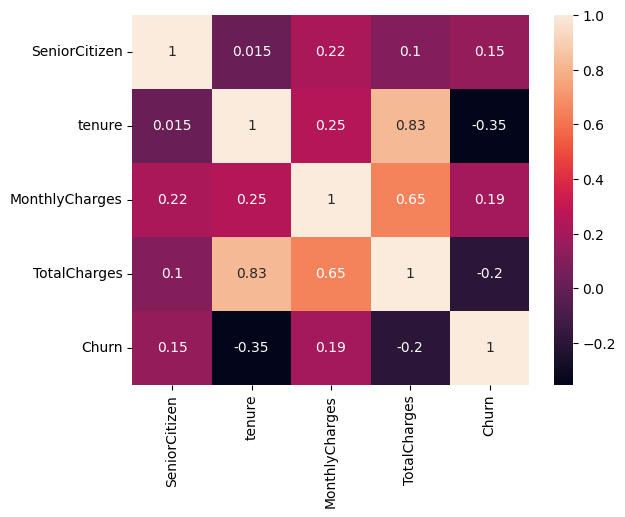

In [24]:
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True)
plt.show()

Tenure has the strongest correlation with churn, followed by MonthlyCharges and TotalCharges. However naturally churn will lead to a lower tenure as customers who churn would be with the company for a shorter period of time. Similarly for TotalCharges. Using MonthlyCharges hence to determine differences in categories will be used

In [25]:
print(df["Churn"].value_counts())
print(df["Churn"].value_counts(normalize=True))

Churn
0    5164
1    1857
Name: count, dtype: int64
Churn
0    0.735508
1    0.264492
Name: proportion, dtype: float64


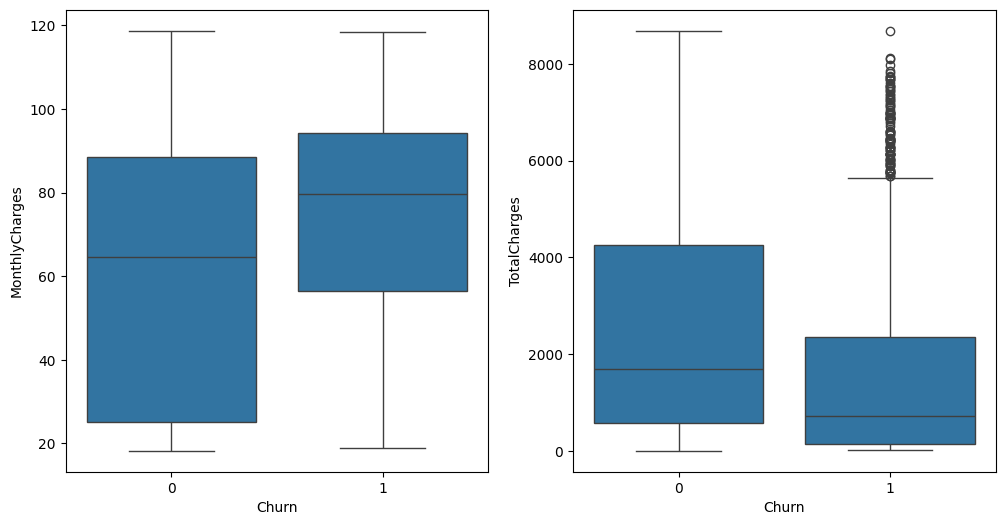

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, ax=axes[0])
sns.boxplot(x="Churn", y="TotalCharges", data=df, ax=axes[1])
plt.show()

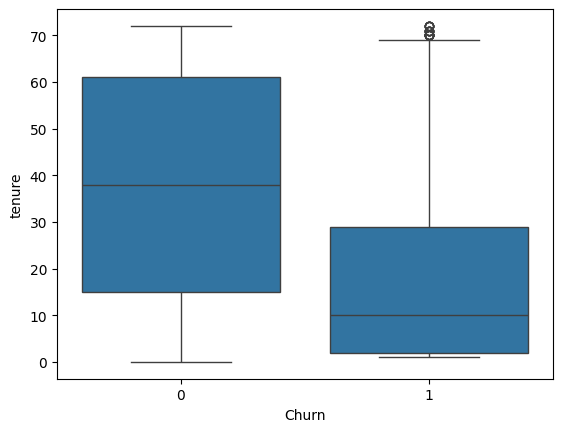

In [27]:
sns.boxplot(x="Churn", y="tenure", data=df)
plt.show()

Comparing Differences in `Monthly Charges` by Categorical Features Between Churn and Non-Churn

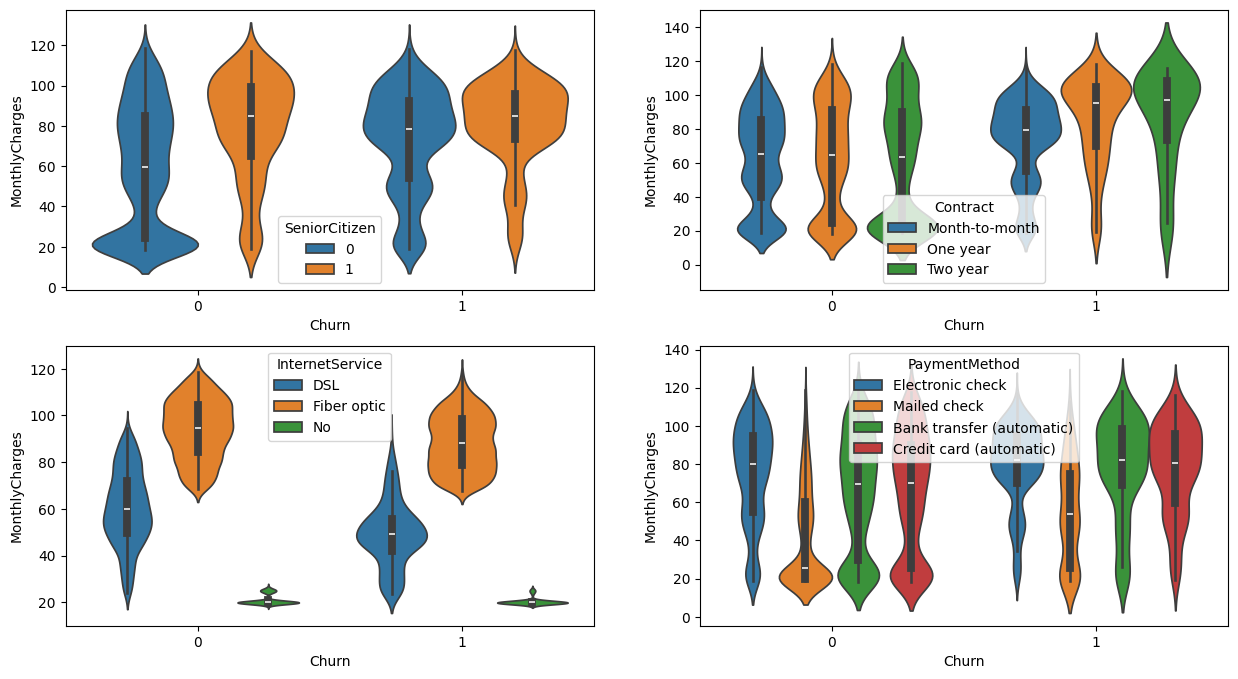

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.violinplot(x="Churn", y="MonthlyCharges", hue="SeniorCitizen", data=df, ax=ax[0, 0])
sns.violinplot(x="Churn", y="MonthlyCharges", hue="Contract", data=df, ax=ax[0, 1])
sns.violinplot(x="Churn", y="MonthlyCharges", hue="InternetService", data=df, ax=ax[1, 0])
sns.violinplot(x="Churn", y="MonthlyCharges", data=df, hue="PaymentMethod", ax=ax[1, 1])
plt.show()

Notable Differences in `Contract` 


In [29]:
df.columns.tolist()

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

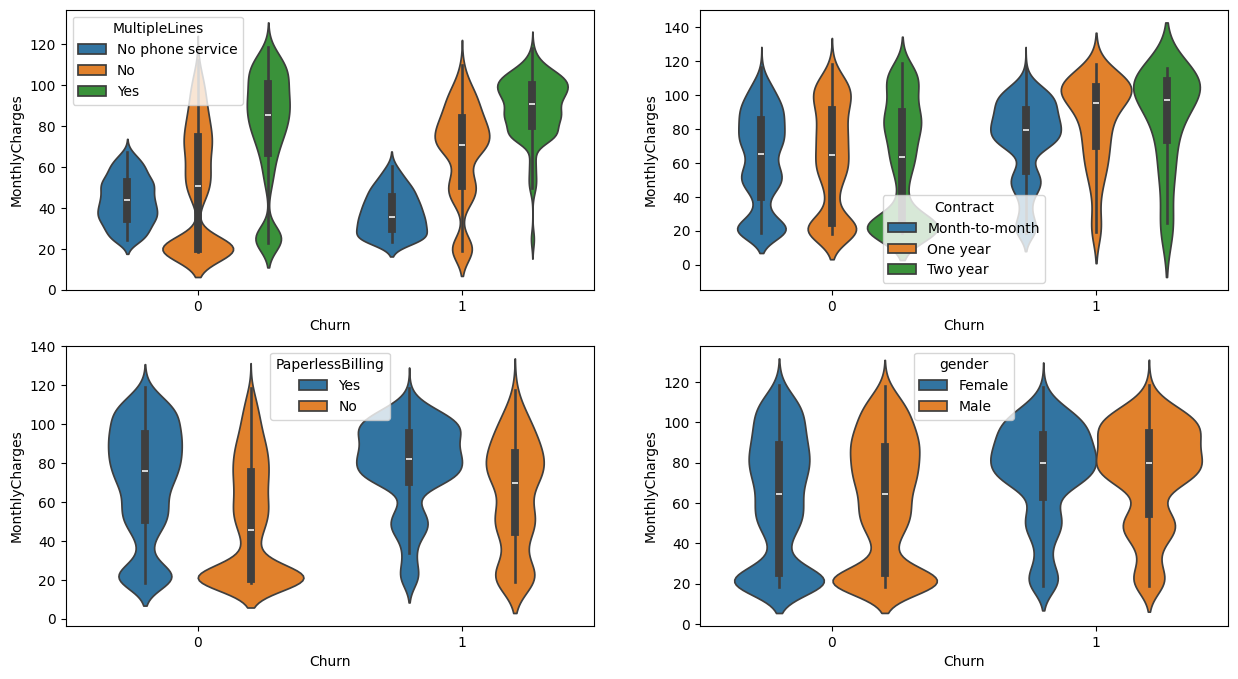

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.violinplot(x="Churn", y="MonthlyCharges", hue="MultipleLines", data=df, ax=ax[0, 0])
sns.violinplot(x="Churn", y="MonthlyCharges", hue="Contract", data=df, ax=ax[0, 1])
sns.violinplot(x="Churn", y="MonthlyCharges", hue="PaperlessBilling", data=df, ax=ax[1, 0])
sns.violinplot(x="Churn", y="MonthlyCharges", hue="gender", data=df, ax=ax[1, 1])
plt.show()

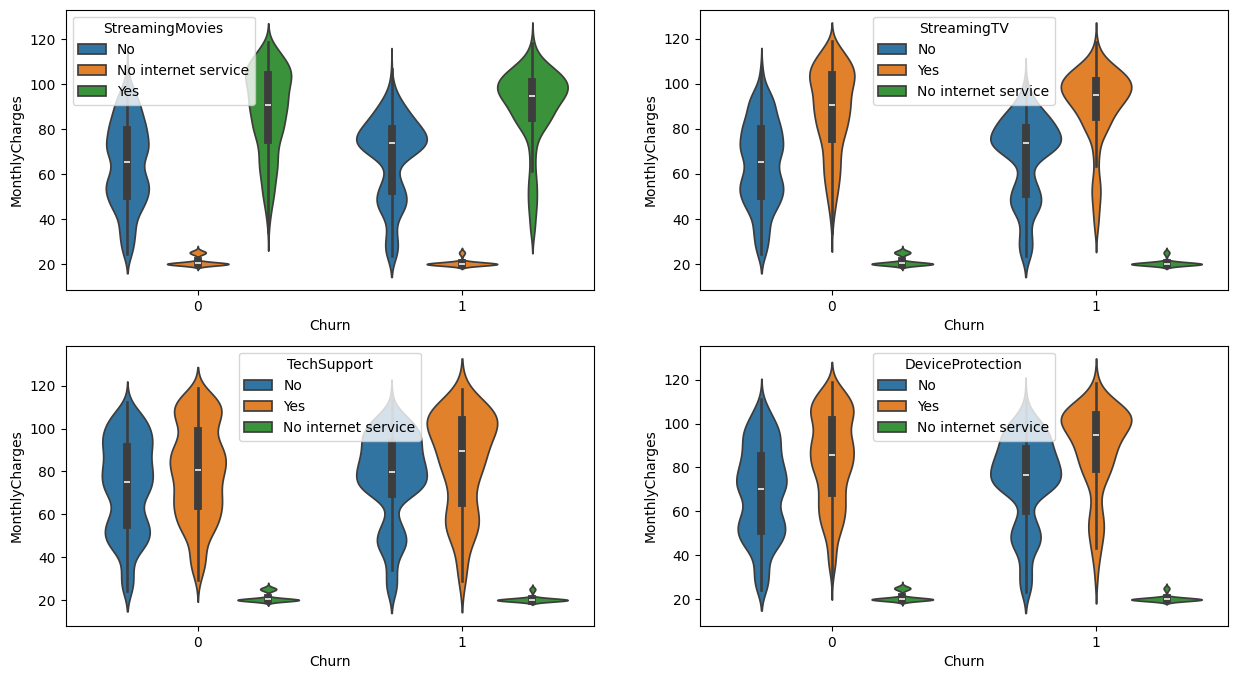

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.violinplot(y="MonthlyCharges", x="Churn", data=df, hue="StreamingMovies", ax=ax[0, 0])
sns.violinplot(y="MonthlyCharges", x="Churn", data=df, hue="StreamingTV", ax=ax[0, 1])
sns.violinplot(y="MonthlyCharges", x="Churn", data=df, hue="TechSupport", ax=ax[1, 0])
sns.violinplot(y="MonthlyCharges", x="Churn", data=df, hue="DeviceProtection", ax=ax[1, 1])
plt.show()

Minor Differences between `Churn` and `Non-Churn` in `MonthlyCharges` among the categorical features.

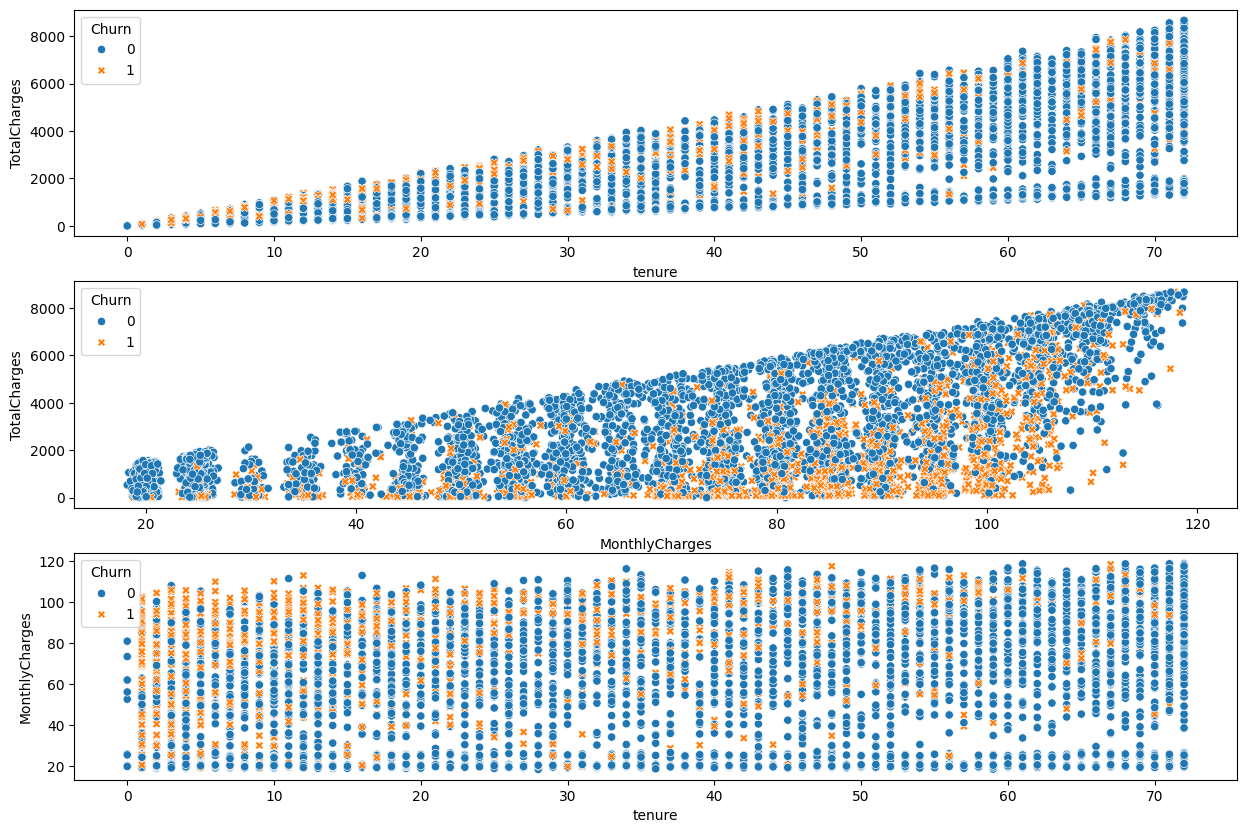

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.scatterplot(x="tenure", y="TotalCharges", data=df, hue="Churn", ax=ax[0], style="Churn")
sns.scatterplot(
    x="MonthlyCharges", y="TotalCharges", data=df, hue="Churn", ax=ax[1], style="Churn"
)
sns.scatterplot(x="tenure", y="MonthlyCharges", data=df, hue="Churn", ax=ax[2], style="Churn")
plt.show()

Customers with higher monthly charges (and hence higher total charges at a given tenure) are more likely to churn

In [33]:
from scipy.stats import chi2_contingency


def analyze_feature_pairs(df: pd.DataFrame, target: str = "Churn") -> pd.DataFrame:
    features = df.select_dtypes(include=["object"]).columns
    results = []

    for i, feat1 in enumerate(features):
        for feat2 in features[i + 1 :]:

            contingency = pd.crosstab(df[feat1], df[feat2])

            # Perform chi-square test
            chi2, p_value, _, _ = chi2_contingency(contingency)

            results.append(
                {"Feature1": feat1, "Feature2": feat2, "Chi2": chi2, "P-value": p_value}
            )

    return pd.DataFrame(results).sort_values("P-value", ascending=True)


pairs = analyze_feature_pairs(df)
pairs[pairs["P-value"] < 0.05]

,Feature1,Feature2,Chi2,P-value
78,OnlineBackup,TechSupport,7273.890992,0.000000e+00
69,OnlineSecurity,OnlineBackup,7245.732525,0.000000e+00
70,OnlineSecurity,DeviceProtection,7222.779148,0.000000e+00
71,OnlineSecurity,TechSupport,7543.717036,0.000000e+00
72,OnlineSecurity,StreamingTV,7033.911541,0.000000e+00
...,...,...,...,...
22,Partner,StreamingTV,130.756057,4.042807e-29
23,Partner,StreamingMovies,116.250476,5.708603e-26
21,Partner,TechSupport,113.209484,2.611397e-25
37,Dependents,PaperlessBilling,87.920878,6.812579e-21


# Model Building

In [34]:
X_train, ex, y_train, ey = train_test_split(
    df.drop(columns=["Churn"]), df["Churn"], test_size=0.3, random_state=593, stratify=df["Churn"]
)

X_test, X_val, y_test, y_val = train_test_split(
    ex, ey, test_size=0.5, random_state=593, stratify=ey
)

Without Standardization & PCA

In [35]:
num_transformer = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        # ("scaler", StandardScaler())
    ]
)


preprocessor = ColumnTransformer(
    [
        ("numerical", num_transformer, numerical_features),
        ("categorical", OneHotEncoder(sparse_output=False), categorical_features),
    ]
)

log_reg_pipe_wo_std_pca = Pipeline(
    [
        ("preprocessor", preprocessor),
        # ("pca", PCA()),
        (
            "log_reg",
            LogisticRegression(n_jobs=-1, class_weight="balanced", warm_start=True, max_iter=1000),
        ),
    ]
)

log_reg_pipe_wo_std_pca

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, warm_start=True))])

Without PCA

In [36]:
num_transformer = Pipeline([("poly", PolynomialFeatures(degree=2)), ("scaler", StandardScaler())])


preprocessor = ColumnTransformer(
    [
        ("numerical", num_transformer, numerical_features),
        ("categorical", OneHotEncoder(sparse_output=False), categorical_features),
    ]
)

log_reg_pipe_wo_pca = Pipeline(
    [
        ("preprocessor", preprocessor),
        # ("pca", PCA()),
        (
            "log_reg",
            LogisticRegression(n_jobs=-1, class_weight="balanced", warm_start=True, max_iter=1000),
        ),
    ]
)

log_reg_pipe_wo_pca

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, warm_start=True))])

With PCA and Standardization

In [37]:
num_transformer = Pipeline([("poly", PolynomialFeatures(degree=2)), ("scaler", StandardScaler())])


preprocessor = ColumnTransformer(
    [
        ("numerical", num_transformer, numerical_features),
        ("categorical", OneHotEncoder(sparse_output=False), categorical_features),
    ]
)

log_reg_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("pca", PCA()),
        (
            "log_reg",
            LogisticRegression(n_jobs=-1, class_weight="balanced", warm_start=True, max_iter=1000),
        ),
    ]
)

log_reg_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('pca', PCA()),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, warm_start=True))])

With PCA and Standardization

In [38]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=593)

param_grid = {
    "log_reg__C": np.linspace(0.0001, 10, 10),
    "log_reg__penalty": ["l2"],
    "log_reg__tol": np.linspace(0.0001, 0.1, 10),
    "log_reg__solver": ["liblinear", "saga"],
}

grid_search = GridSearchCV(
    log_reg_pipe, param_grid, cv=kf, scoring="balanced_accuracy", n_jobs=-1
)  # balanced_accuracy
grid_search.fit(X_train, y_train)
preds = grid_search.predict(X_val)

/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logist

Without Standardization & PCA


In [39]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=593)

param_grid = {
    "log_reg__C": np.linspace(0.0001, 10, 10),
    "log_reg__penalty": ["l2"],
    "log_reg__tol": np.linspace(0.0001, 0.1, 10),
    "log_reg__solver": ["liblinear", "saga"],
}

grid_search_wo_std_pca = GridSearchCV(
    log_reg_pipe_wo_std_pca, param_grid, cv=kf, scoring="balanced_accuracy", n_jobs=-1
)  # balanced_accuracy
grid_search_wo_std_pca.fit(X_train, y_train)
preds_wo_std_pca = grid_search_wo_std_pca.predict(X_val)

/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logist

Without PCA

In [40]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=593)

param_grid = {
    "log_reg__C": np.linspace(0.0001, 10, 10),
    "log_reg__penalty": ["l2"],
    "log_reg__tol": np.linspace(0.0001, 0.1, 10),
    "log_reg__solver": ["liblinear", "saga"],
}

grid_search_wo_pca = GridSearchCV(
    log_reg_pipe_wo_pca, param_grid, cv=kf, scoring="balanced_accuracy", n_jobs=-1
)  # balanced_accuracy
grid_search_wo_pca.fit(X_train, y_train)
preds_wo_pca = grid_search_wo_pca.predict(X_val)

/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logist

In [41]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best balanced accuracy train score: {grid_search.best_score_:.2f}")

best parameters: {'log_reg__C': np.float64(5.5556), 'log_reg__penalty': 'l2', 'log_reg__solver': 'saga', 'log_reg__tol': np.float64(0.0889)}
best balanced accuracy train score: 0.76


In [42]:
# wo pca
print(f"best parameters: {grid_search_wo_pca.best_params_}")
print(f"best balanced accuracy train score: {grid_search_wo_pca.best_score_:.2f}")

best parameters: {'log_reg__C': np.float64(10.0), 'log_reg__penalty': 'l2', 'log_reg__solver': 'saga', 'log_reg__tol': np.float64(0.0223)}
best balanced accuracy train score: 0.76


In [43]:
# wo std pca
print(f"best parameters: {grid_search_wo_std_pca.best_params_}")
print(f"best balanced accuracy train score: {grid_search_wo_std_pca.best_score_:.2f}")

best parameters: {'log_reg__C': np.float64(7.777799999999999), 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear', 'log_reg__tol': np.float64(0.0001)}
best balanced accuracy train score: 0.72


Validation

In [44]:
print("with PCA and Standardization")
print(classification_report(y_val, preds))
print("-" * 100)
# wo pca
print("without PCA")
print(classification_report(y_val, preds_wo_pca))
print("-" * 100)
# wo std pca
print("without Standardization & PCA")
print(classification_report(y_val, preds_wo_std_pca))

with PCA and Standardization
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       775
           1       0.54      0.83      0.66       279

    accuracy                           0.77      1054
   macro avg       0.73      0.79      0.74      1054
weighted avg       0.82      0.77      0.78      1054

----------------------------------------------------------------------------------------------------
without PCA
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       775
           1       0.55      0.83      0.66       279

    accuracy                           0.77      1054
   macro avg       0.74      0.79      0.74      1054
weighted avg       0.82      0.77      0.78      1054

----------------------------------------------------------------------------------------------------
without Standardization & PCA
              precision    recall  f1-score   support

           0      

In [45]:
from sklearn.metrics import balanced_accuracy_score

print("with PCA and Standardization")
print(f"{balanced_accuracy_score(y_val, preds):.2f}")
# wo pca
print("without PCA")
print(f"{balanced_accuracy_score(y_val, preds_wo_pca):.2f}")
# wo std pca
print("without Standardization & PCA")
print(f"{balanced_accuracy_score(y_val, preds_wo_std_pca):.2f}")

with PCA and Standardization
0.79
without PCA
0.79
without Standardization & PCA
0.74


With PCA and Standardisation


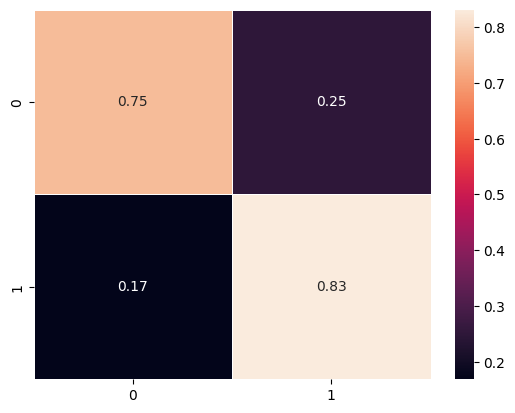

----------------------------------------------------------------------------------------------------
Without PCA


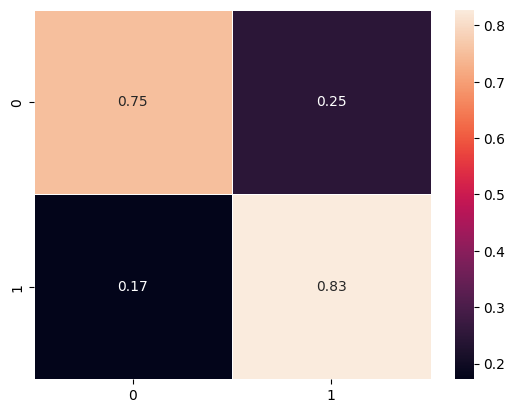

----------------------------------------------------------------------------------------------------
Without Standardization & PCA


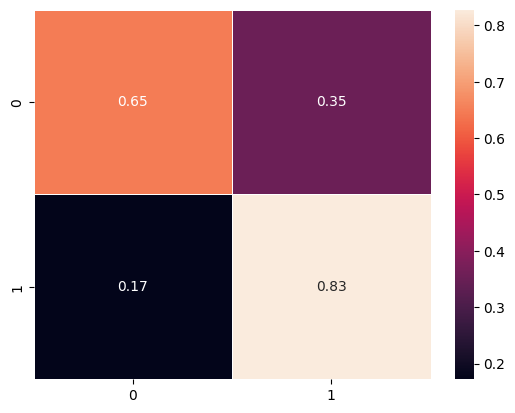

In [46]:
from sklearn.metrics import confusion_matrix

print("With PCA and Standardisation")
sns.heatmap(
    confusion_matrix(y_val, preds, normalize="true"),
    annot=True,
    linewidths=0.5,
    linecolor="white",
)
plt.show()

print("-" * 100)
print("Without PCA")
sns.heatmap(
    confusion_matrix(y_val, preds_wo_pca, normalize="true"),
    annot=True,
    linewidths=0.5,
    linecolor="white",
)
plt.show()

print("-" * 100)
print("Without Standardization & PCA")
sns.heatmap(
    confusion_matrix(y_val, preds_wo_std_pca, normalize="true"),
    annot=True,
    linewidths=0.5,
    linecolor="white",
)
plt.show()

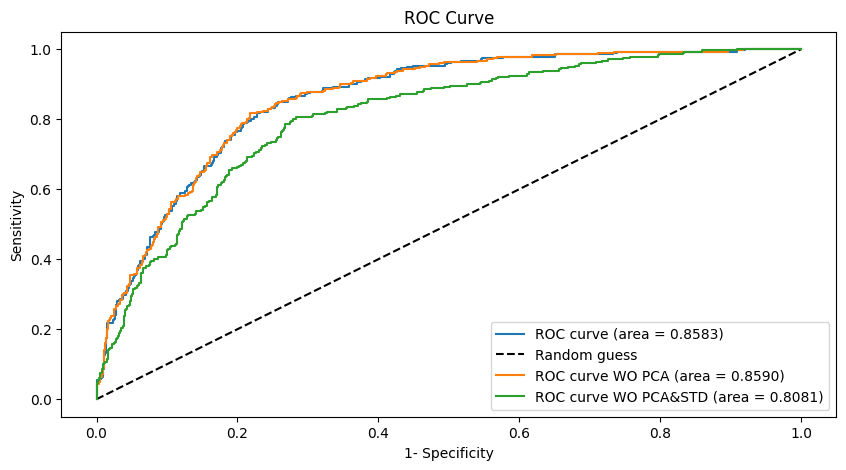

In [47]:
plt.figure(figsize=(10, 5))

preds_prob = grid_search.predict_proba(X_val)[:, 1]
preds_prob_wo_pca = grid_search_wo_pca.predict_proba(X_val)[:, 1]
preds_prob_wo_std_pca = grid_search_wo_std_pca.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, preds_prob)
fpr_wo_pca, tpr_wo_pca, thresholds_wo_pca = roc_curve(y_val, preds_prob_wo_pca)
fpr_wo_std_pca, tpr_wo_std_pca, thresholds_wo_std_pca = roc_curve(y_val, preds_prob_wo_std_pca)

roc_auc = auc(fpr, tpr)
roc_auc_wo_pca = auc(fpr_wo_pca, tpr_wo_pca)
roc_auc_wo_std_pca = auc(fpr_wo_std_pca, tpr_wo_std_pca)

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")

plt.plot(fpr_wo_pca, tpr_wo_pca, label=f"ROC curve WO PCA (area = {roc_auc_wo_pca:.4f})")

plt.plot(
    fpr_wo_std_pca, tpr_wo_std_pca, label=f"ROC curve WO PCA&STD (area = {roc_auc_wo_std_pca:.4f})"
)


plt.legend()
plt.xlabel("1- Specificity")
plt.ylabel(
    "Sensitivity",
)
plt.title("ROC Curve")
plt.show()

Best Model: With PCA and Standardization

In [48]:
predictions = grid_search.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       775
           1       0.53      0.80      0.64       278

    accuracy                           0.76      1053
   macro avg       0.72      0.78      0.73      1053
weighted avg       0.81      0.76      0.77      1053



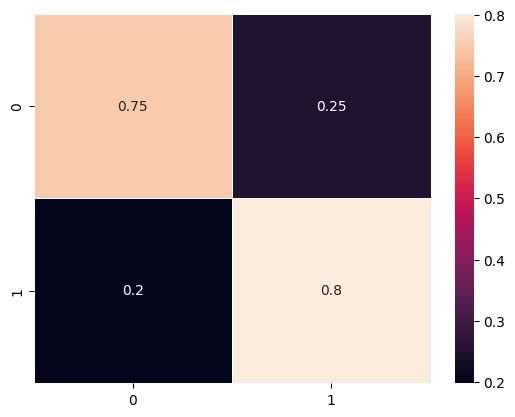

In [49]:
sns.heatmap(
    confusion_matrix(y_test, predictions, normalize="true"),
    annot=True,
    linewidths=0.5,
    linecolor="white",
)
plt.show()

In [50]:
print(f"{balanced_accuracy_score(y_test, predictions):.3f}")

0.775


In [51]:
from sklearn.metrics import roc_auc_score

print(f"{roc_auc_score(y_test, predictions):.3f}")

0.775


In [61]:
import pickle

with open("model.pkl", "wb") as model_file:
    pickle.dump(grid_search, model_file)